# AI-Based Trading Strategies

## CNN-LSTM Trading Strategy

### Import Libraries & Dependencies

In [1]:
# ================================
# --- Standard Libraries ---
# ================================
import os
import shutil
import warnings
import logging
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd

# ================================
# --- Visualization ---
# ================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# ================================
# --- Stats & ML ---
# ================================
from scipy.stats import mode
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import ExtraTreesClassifier
from hmmlearn.hmm import GaussianHMM

# ================================
# --- Deep Learning ---
# ================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ================================
# --- Quant & Finance ---
# ================================
import quantstats as qs

# ================================
# --- Utilities / Pretty Printing ---
# ================================
from tabulate import tabulate

# ================================
# --- Settings ---
# ================================
warnings.filterwarnings("ignore", category=FutureWarning, module="quantstats")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

OUTPUT_DIR = Path("../outputs/03_CNN_LSTM")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)



In [2]:
# --- Load Local Dataset ---
data_path = Path('../data/GSPC_fixed.csv')
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path.resolve()}")

df = pd.read_csv(
    data_path,
    parse_dates=['Date'],
    index_col='Date'
).sort_index()

df.columns = [col.lower() for col in df.columns]

numeric_cols = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.ffill(inplace=True)

display(df.head())
display(df.tail())


,open,high,low,close,adjusted_close,volume
Date,,,,,,
2014-01-06,1832.3101,1837.16,1823.7300,1826.77,1826.77,3294850000
2014-01-07,1828.7100,1840.10,1828.7100,1837.88,1837.88,3511750000
2014-01-08,1837.9000,1840.02,1831.4000,1837.49,1837.49,3652140000
2014-01-09,1839.0000,1843.23,1830.3800,1838.13,1838.13,3581150000
2014-01-10,1840.0601,1843.15,1832.4301,1842.37,1842.37,3335710000


,open,high,low,close,adjusted_close,volume
Date,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000


## Data Visualization
- Plot **S&P 500 adjusted closing prices** over time.

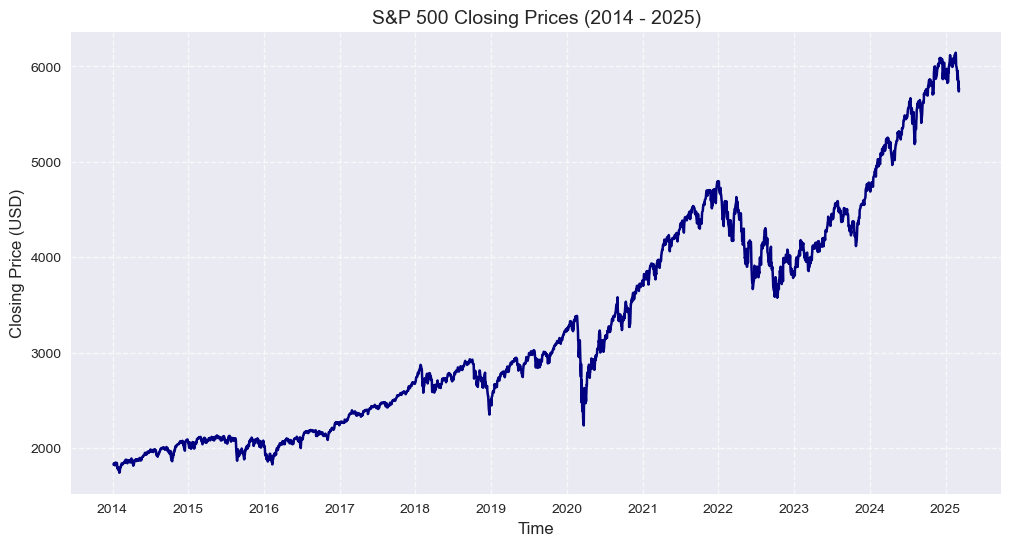

In [3]:
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["adjusted_close"], linewidth=1.8, color='navy')

plt.title("S&P 500 Closing Prices (2014 - 2025)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.show()

## Feature Engineering & Transformation

In [4]:
# Compute log returns
df["log_returns"] = np.log(df["adjusted_close"] / df["adjusted_close"].shift(1))

### Volatility-Adjusted Returns:

In [5]:
# Rolling Volatility (10-day)
df["volatility_10"] = df["log_returns"].rolling(10).std()

# Volatility-Adjusted Returns
df["vol_adj_returns"] = df["log_returns"] / df["volatility_10"]

df.dropna(inplace=True)
df.head()

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns
Date,,,,,,,,,
2014-01-21,1841.05,1849.3101,1832.3800,1843.8000,1843.8000,3782470000,0.002770,0.006332,0.437438
2014-01-22,1844.71,1846.8700,1840.8800,1844.8600,1844.8600,3374170000,0.000575,0.006070,0.094687
2014-01-23,1842.29,1842.2900,1820.0601,1828.4600,1828.4600,3972250000,-0.008929,0.006752,-1.322501
2014-01-24,1826.96,1826.9600,1790.2900,1790.2900,1790.2900,4618450000,-0.021096,0.009358,-2.254436
2014-01-27,1791.03,1795.9800,1772.8800,1781.5601,1781.5601,4045200000,-0.004888,0.009211,-0.530687


### Technical Indicators  

LSTM models **learn patterns from sequences**, so we should select indicators that enhance **trend detection, volatility awareness, and momentum signals**.

| **Category**              | **Indicator**                                      | **Best Periods** | **Why Useful?**                                   |
|---------------------------|---------------------------------------------------|----------------|--------------------------------------------------|
| **Moving Averages**        | **EMA (Exponential Moving Avg)**                 | **EMA(50, 200)** | Captures recent trend changes faster           |
| **Momentum Indicators**    | **RSI (Relative Strength Index)**                | **RSI(14)** | Identifies momentum & overbought/oversold conditions   |
| **Momentum Indicators**    | **MACD (Moving Avg Convergence Divergence)**     | **MACD(12,26,9)** | Detects momentum shifts & trend reversals   |
| **Volatility Indicators**  | **ATR (Average True Range)**                     | **ATR(14)** | Measures market volatility & stop-loss adjustments        |
| **Trend Indicators**       | **SAR (Parabolic SAR)**                          | **SAR(Default)** | Tracks trend direction & reversals                        |
| **Trend Indicators**       | **SLOPE (Slope Indicator)**                      | **SLOPE(14)** | Confirms trend strength                        |
| **Trend Indicators**       | **ADX (Average Directional Index)**              | **ADX(14)** | Measures trend strength without direction |
| **Volume Indicators**      | **OBV (On-Balance Volume)**                      | **OBV(Default)** | Confirms trend strength via volume              |


In [6]:
# Momentum Indicators: RSI & MACD
def compute_rsi(df, column="adjusted_close", period=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(df, column="adjusted_close", short_period=12, long_period=26, signal_period=9):
    short_ema = df[column].ewm(span=short_period, adjust=False).mean()
    long_ema = df[column].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# Moving Averages: EMA 50 & EMA 200
def compute_ema(df, column="adjusted_close", period=50):
    return df[column].ewm(span=period, adjust=False).mean()

def compute_ema_200(df, column="adjusted_close", period=200):
    return df[column].ewm(span=period, adjust=False).mean()

# Volatility Indicator: ATR
def compute_atr(df, period=14):
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    return tr.rolling(window=period).mean()

# Trend Indicators: SAR, Slope & ADX
def compute_slope(df, column="adjusted_close", period=14):
    return df[column].diff(period) / period

def compute_sar(df, acceleration=0.02, maximum=0.2):
    sar = np.zeros(len(df))
    trend = 1  # Assume first trend is bullish
    extreme_point = df["high"].iloc[0]
    af = acceleration
    
    for i in range(1, len(df)):
        sar[i] = sar[i - 1] + af * (extreme_point - sar[i - 1]) if trend == 1 else sar[i - 1] - af * (sar[i - 1] - extreme_point)
        extreme_point = max(extreme_point, df["high"].iloc[i]) if trend == 1 else min(extreme_point, df["low"].iloc[i])
        af = min(af + acceleration, maximum)
    return sar

def compute_adx(df, period=14):
    plus_dm = np.maximum(df["high"].diff(), 0)
    minus_dm = np.maximum(-df["low"].diff(), 0)
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    return dx.rolling(window=period).mean()

# Volume Indicator: OBV
def compute_obv_vectorized(df):
    direction = np.sign(df["adjusted_close"].diff()).fillna(0)
    return (direction * df["volume"]).cumsum()


# Compute Indicators and Add to DataFrame
df["EMA_50"] = compute_ema(df, period=50)
df["EMA_200"] = compute_ema_200(df, period=200)
df["RSI_14"] = compute_rsi(df, period=14)
df["MACD"], df["MACD_Signal"] = compute_macd(df)
df["ATR_14"] = compute_atr(df, period=14)
df["SAR"] = compute_sar(df)
df["SLOPE_14"] = compute_slope(df, period=14)
df["ADX_14"] = compute_adx(df, period=14)
df["OBV"] = compute_obv_vectorized(df)

# Fill any NaNs from rolling calculations
df.fillna(0, inplace=True)

In [7]:
df.tail()

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,EMA_200,RSI_14,MACD,MACD_Signal,ATR_14,SAR,SLOPE_14,ADX_14,OBV
Date,,,,,,,,,,,,,,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000,-0.017753,0.010518,-1.687854,5994.162275,5707.587282,31.744069,-28.348137,-1.175908,77.079236,6144.157167,-15.479979,23.276308,6.772605e+11
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000,-0.012310,0.010482,-1.174418,5985.691202,5708.289397,28.105619,-42.036866,-9.348100,84.118543,6144.811774,-20.739293,26.684097,6.711224e+11
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000,0.011097,0.011556,0.960360,5980.080954,5709.626119,35.278876,-47.138898,-16.906259,87.885664,6145.335459,-14.952879,29.099143,6.764084e+11
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000,-0.017980,0.012249,-1.467844,5970.607976,5709.913620,24.964456,-58.904085,-25.305824,92.530650,6145.754407,-26.896414,33.535151,6.712433e+11
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000,0.005505,0.012126,0.454013,5962.748847,5710.513486,28.013368,-64.923356,-33.229331,99.449914,6146.089566,-24.602121,37.614856,6.769485e+11


### Regime Detection:
Use Hidden Markov Models (HMMs) to identify market regimes (bull/bear) and create regime-specific features.

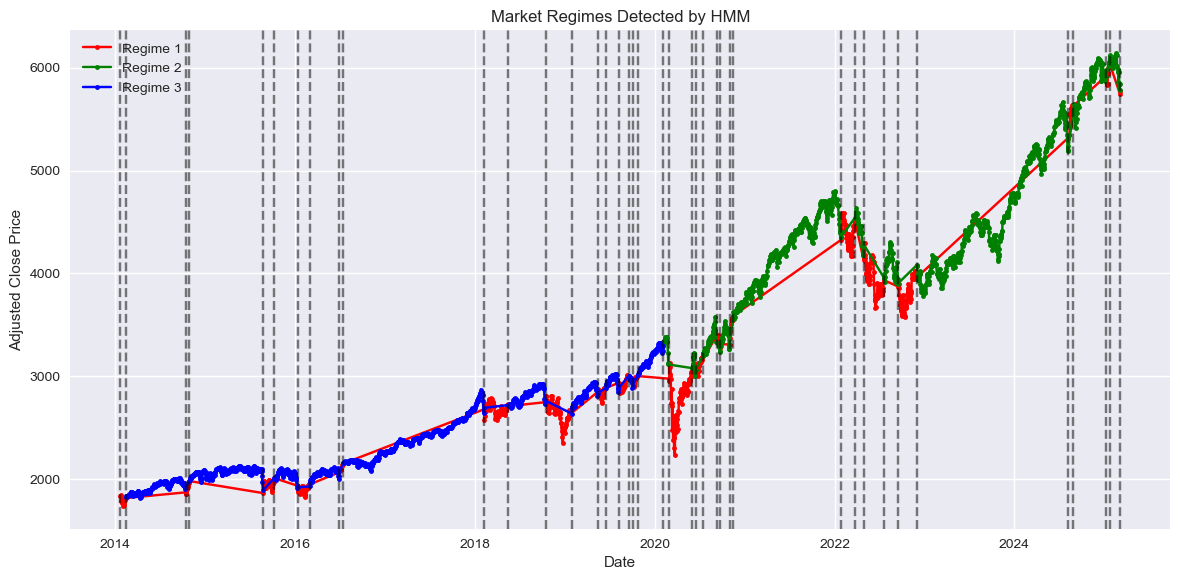

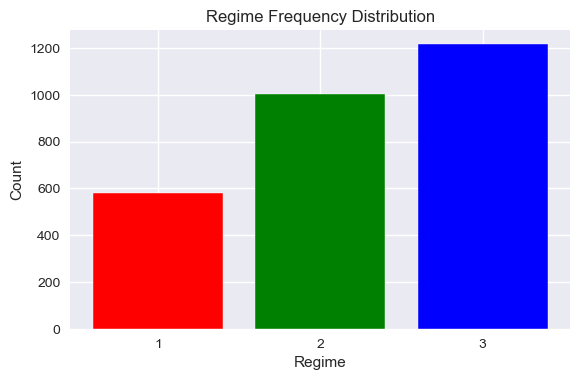

In [8]:
# =========================
# Regime Detection with HMM
# =========================

# --- Step 1: Define Number of Hidden States (Regimes) ---
n_states = 3  # 3 regimes: Bullish, Bearish, Neutral

# --- Step 2: Regime Detection with HMM ---
# Selecting relevant features for HMM training
hmm_features = ["log_returns", "volatility_10", "RSI_14", "MACD", "ATR_14", "OBV"]

df_hmm = df[hmm_features].dropna()  # Avoid missing values
X = df_hmm.values  

# --- Step 3: Normalize Features for HMM ---
scaler_hmm = StandardScaler()
X_hmm_scaled = scaler_hmm.fit_transform(X)  # Standardize only HMM features

# --- Step 4: Train HMM Model ---
hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
hmm_model.fit(X_hmm_scaled)

# --- Step 5: Predict Market Regimes ---
df.loc[df_hmm.index, "regime"] = hmm_model.predict(X_hmm_scaled)

# --- Step 6: Ensure all rows have a regime assigned ---
df["regime"] = df["regime"].ffill().bfill()  

# --- Step 7: Apply Smoothing to Reduce Noise in Regime Changes ---
def rolling_mode(series, window=7):
    def safe_mode(x):
        m = mode(x, keepdims=True)
        return m.mode[0] if len(m.mode) > 0 else x.iloc[-1]
    # FIX: Use strictly forward-looking rolling (center=False)
    return series.rolling(window, center=False).apply(safe_mode, raw=False)

df["regime_smoothed"] = rolling_mode(df["regime"], window=7).ffill().bfill().astype(int)

# --- Step 8: Mark Major Regime Change Points ---
# FIX: Remove lookahead by not using shift(-15)
df["regime_change"] = df["regime_smoothed"].diff().ne(0).astype(int)
# (Optional alternative: If you prefer to confirm a change after 15 days, you could delay labeling:
# df["regime_change"] = df["regime_smoothed"].diff().ne(0).shift(15).fillna(0).astype(int))

# --- Step 9: Creating Regime-Based Features ---
# To avoid mixing non-contiguous periods with the same regime label, we create a block id:
df["block_id"] = df["regime_smoothed"].ne(df["regime_smoothed"].shift()).cumsum()

def regime_sma(df, column, window):
    # Compute rolling average within each contiguous block only
    return df.groupby("block_id")[column].apply(lambda x: x.rolling(window, min_periods=1).mean()).reset_index(level=0, drop=True)

# Apply Regime-Based Features
df["SMA_50_regime"] = regime_sma(df, "adjusted_close", 50)
df["SMA_200_regime"] = regime_sma(df, "adjusted_close", 200)
df["volatility_10_regime"] = regime_sma(df, "volatility_10", 10)
df["RSI_14_regime"] = regime_sma(df, "RSI_14", 14)

df.dropna(inplace=True)  # Drop rows with missing values

# --- Step 10: Fixing Regime Mapping and Visualization ---
# Remap 0,1,2 → 1,2,3 for consistent labeling
df["regime_smoothed"] = df["regime_smoothed"].map({0: 1, 1: 2, 2: 3})

# Define color mapping and labels for visualization
regime_colors = {1: "red", 2: "green", 3: "blue"}
regime_labels = {1: "Regime 1", 2: "Regime 2", 3: "Regime 3"}

plt.figure(figsize=(12, 6))
# Plot regime-based adjusted close prices
for regime, color in regime_colors.items():
    plt.plot(df[df["regime_smoothed"] == regime].index,
             df[df["regime_smoothed"] == regime]["adjusted_close"],
             linestyle='-', marker='.', label=regime_labels[regime], color=color)
# Highlight regime change points
for change_date in df[df["regime_change"] == 1].index:
    plt.axvline(change_date, color='black', linestyle="--", alpha=0.5)
plt.title("Market Regimes Detected by HMM")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "1_regime_detection_chart.png", dpi=150, bbox_inches='tight')
plt.show()


# --- Step 11: Fixed Regime Frequency Distribution ---
plt.figure(figsize=(6, 4))
regime_counts = df["regime_smoothed"].value_counts().sort_index()
bars = plt.bar(regime_counts.index, regime_counts.values, color=[regime_colors[i] for i in regime_counts.index])
plt.xticks(ticks=regime_counts.index, labels=regime_counts.index)
plt.title("Regime Frequency Distribution")
plt.xlabel("Regime")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "2_regime_frequency_distribution.png", dpi=150, bbox_inches='tight')
plt.show()



In [9]:
# --- Step 1: Ensure "regime_smoothed" Exists  ---
if "regime_smoothed" not in df.columns:
    print("Warning: 'regime_smoothed' column is missing! Recreating it...")
    if "regime" in df.columns:
        df["regime_smoothed"] = df["regime"].astype(int)
    else:
        raise KeyError("Error: Neither 'regime_smoothed' nor 'regime' found in DataFrame!")

# --- Step 2: Drop Any Old One-Hot Encoded Regime Columns (But NOT "regime_smoothed") ---
old_regime_cols = [col for col in df.columns if col.startswith("regime_") and col != "regime_smoothed"]
if old_regime_cols:
    df.drop(columns=old_regime_cols, inplace=True, errors="ignore")
    
# Preserve "regime_smoothed" before encoding to prevent KeyErrors
df["regime_smoothed_backup"] = df["regime_smoothed"]

# --- Step 3: One-Hot Encode Regimes for LSTM Training ---
df = pd.get_dummies(df, columns=["regime_smoothed"], prefix="regime")

# Ensure All Expected Regime Columns Exist (Fixes Missing regime_1)
expected_regimes = ["regime_1", "regime_2", "regime_3"]
for col in expected_regimes:
    if col not in df.columns:
        df[col] = 0  # Add missing regime column and fill with 0s

if "regime_smoothed" not in df.columns:
    df["regime_smoothed"] = df["regime_smoothed_backup"]
    
df.drop(columns=["regime_smoothed_backup"], inplace=True, errors="ignore")

# --- Step 4: Convert One-Hot Encoded Values to Integers ---
df[expected_regimes] = df[expected_regimes].astype(int)

# --- Step 5: Verify the Fix ---
display(df.tail())  # Check if columns are correct

print("Regime counts in dataset:")
print(df[expected_regimes].sum())  # Count number of rows for each regime

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,...,regime,block_id,SMA_50_regime,SMA_200_regime,volatility_10_regime,RSI_14_regime,regime_1,regime_2,regime_3,regime_smoothed
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000,-0.017753,0.010518,-1.687854,5994.162275,...,0.0,39,6040.076414,6040.076414,0.007465,46.900147,0,1,0,2
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000,-0.012310,0.010482,-1.174418,5985.691202,...,0.0,39,6031.044466,6031.044466,0.007949,45.458966,0,1,0,2
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000,0.011097,0.011556,0.960360,5980.080954,...,0.0,39,6024.763980,6024.763980,0.008567,44.880087,0,1,0,2
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000,-0.017980,0.012249,-1.467844,5970.607976,...,0.0,40,5738.520000,5738.520000,0.012249,24.964456,1,0,0,1
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000,0.005505,0.012126,0.454013,5962.748847,...,0.0,40,5754.360100,5754.360100,0.012188,26.488912,1,0,0,1


Regime counts in dataset:
regime_1     581
regime_2    1003
regime_3    1216
dtype: int64


### Adding Lag Features (`lag_1` to `lag_7`) 

In [10]:
# Generate lag features (up to 7 days)
lags = 7
for lag in range(1, lags + 1):
    df[f'lag_{lag}'] = df['log_returns'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)

# Check DataFrame structure after adding lag features 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2793 entries, 2014-01-30 to 2025-03-07
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  2793 non-null   float64
 1   high                  2793 non-null   float64
 2   low                   2793 non-null   float64
 3   close                 2793 non-null   float64
 4   adjusted_close        2793 non-null   float64
 5   volume                2793 non-null   int64  
 6   log_returns           2793 non-null   float64
 7   volatility_10         2793 non-null   float64
 8   vol_adj_returns       2793 non-null   float64
 9   EMA_50                2793 non-null   float64
 10  EMA_200               2793 non-null   float64
 11  RSI_14                2793 non-null   float64
 12  MACD                  2793 non-null   float64
 13  MACD_Signal           2793 non-null   float64
 14  ATR_14                2793 non-null   float64
 15  SAR

### Feature Correlation Matrix 

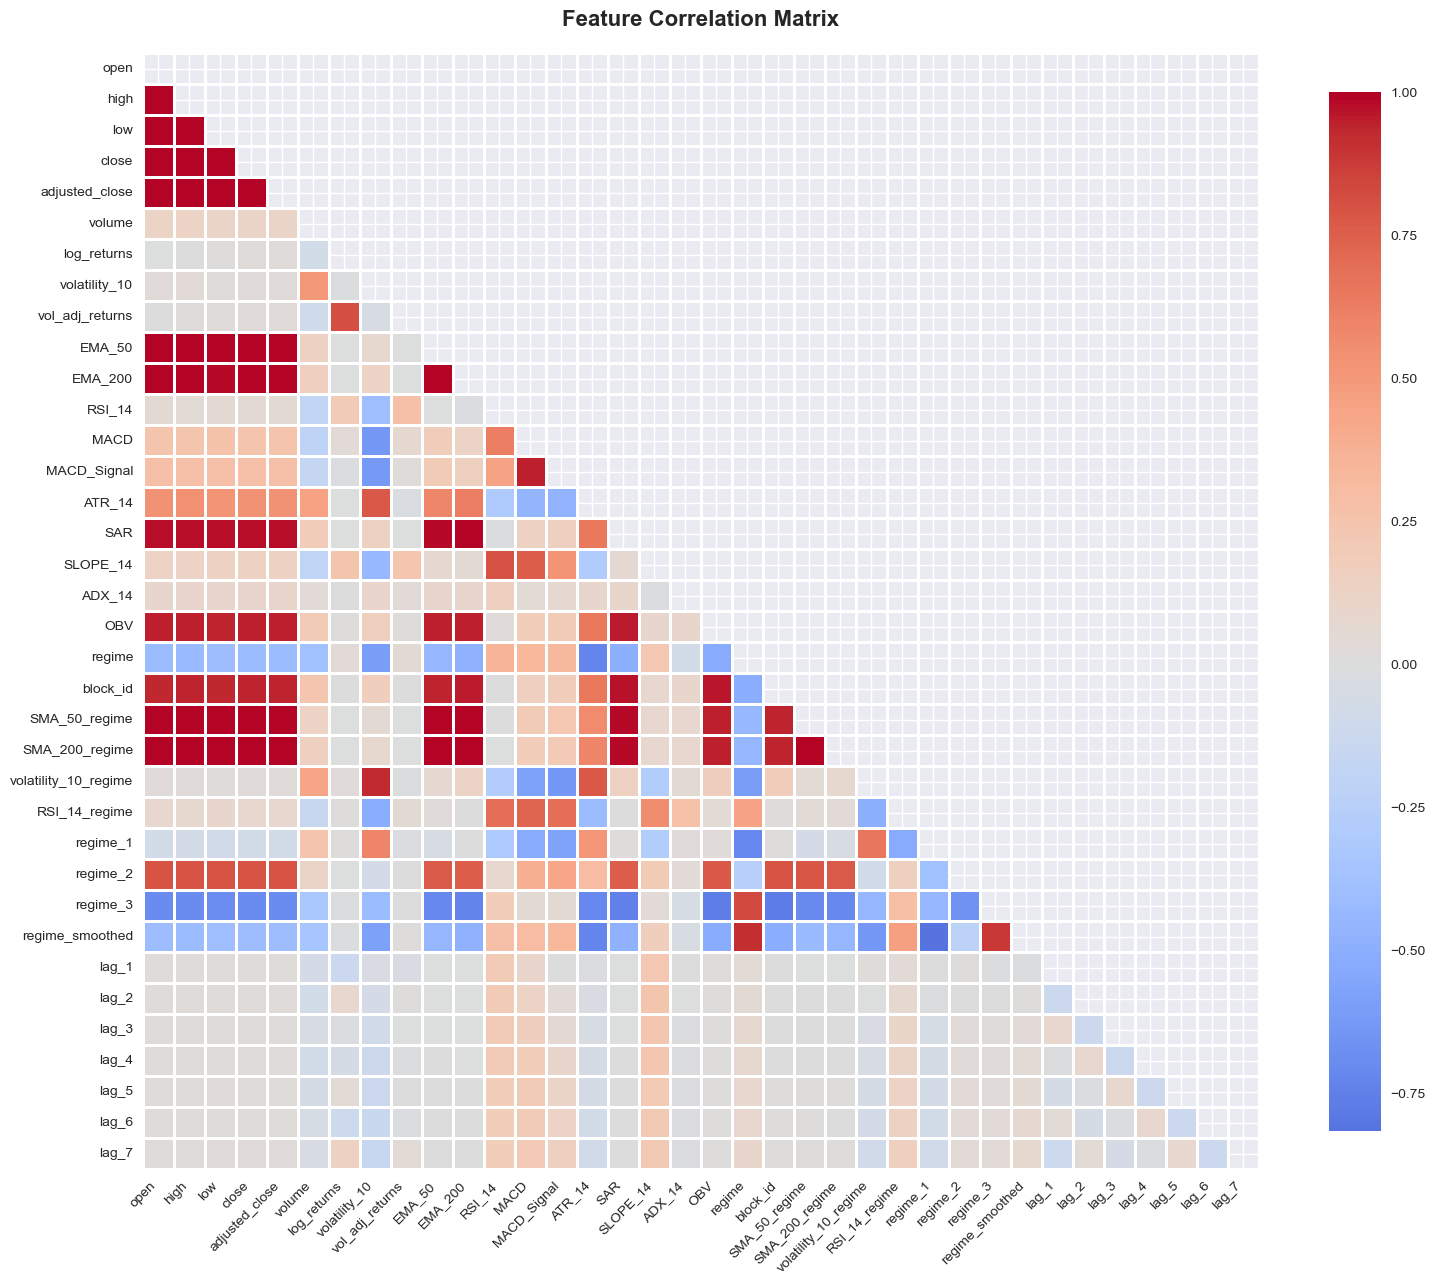

In [11]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Generate a mask to hide the upper triangle (reduce redundancy)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Dynamic figure sizing based on the number of features
n_features = corr_matrix.shape[0]
plt.figure(figsize=(n_features * 0.5, n_features * 0.5))  # Adjust multiplier if needed

sns.heatmap(
    corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=1, cbar_kws={"shrink": 0.75}, square=True
)

# Label formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Feature Correlation Matrix", fontsize=16, fontweight='bold', pad=20)

# Save figure (Change filename & format as needed)
plt.savefig(OUTPUT_DIR / "3_feature_correlation_matrix.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Definition of Target Variable (`d`)

In [12]:
# --- Define Target Variable (`d`) ---
df['d'] = np.where(df['log_returns'].shift(-1) > 0, 1, 0)

# Drop only NaN values in 'd' caused by shifting (Last row)
df.dropna(subset=['d'], inplace=True)

# --- Corrected Feature Selection (X) ---
X = df[[col for col in [
    'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'log_returns', 
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 
    'volatility_10', 'vol_adj_returns', 'EMA_50', 'EMA_200',
    'RSI_14', 'MACD', 'MACD_Signal', 'ATR_14', 'SAR',
    'SLOPE_14', 'ADX_14', 'OBV', 'SMA_50_regime', 'SMA_200_regime', 
    'volatility_10_regime', 'RSI_14_regime', 'regime', 'regime_1', 'regime_2', 'regime_3'
] if col in df.columns]]  # Only include columns that exist

# --- Define Target Variable (y) ---
y = df['d']

# Verify Structure
print("Feature Matrix (X) Shape:", X.shape)
print("Target Variable (y) Shape:", y.shape)
display(df.tail())

Feature Matrix (X) Shape: (2793, 34)
Target Variable (y) Shape: (2793,)


,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,...,regime_3,regime_smoothed,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,d
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000,-0.017753,0.010518,-1.687854,5994.162275,...,0,2,0.015730,-0.015992,0.000136,-0.004691,-0.004981,-0.017211,-0.004344,0
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000,-0.012310,0.010482,-1.174418,5985.691202,...,0,2,-0.017753,0.015730,-0.015992,0.000136,-0.004691,-0.004981,-0.017211,1
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000,0.011097,0.011556,0.960360,5980.080954,...,0,2,-0.012310,-0.017753,0.015730,-0.015992,0.000136,-0.004691,-0.004981,0
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000,-0.017980,0.012249,-1.467844,5970.607976,...,0,1,0.011097,-0.012310,-0.017753,0.015730,-0.015992,0.000136,-0.004691,1
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000,0.005505,0.012126,0.454013,5962.748847,...,0,1,-0.017980,0.011097,-0.012310,-0.017753,0.015730,-0.015992,0.000136,0


In [13]:
print(df['d'].value_counts(normalize=True))

d
1    0.540637
0    0.459363
Name: proportion, dtype: float64


### Feature Selection Using `ExtraTreesClassifier`

Training set shape: (1996, 34) (1996,)
Test set shape: (797, 34) (797,)


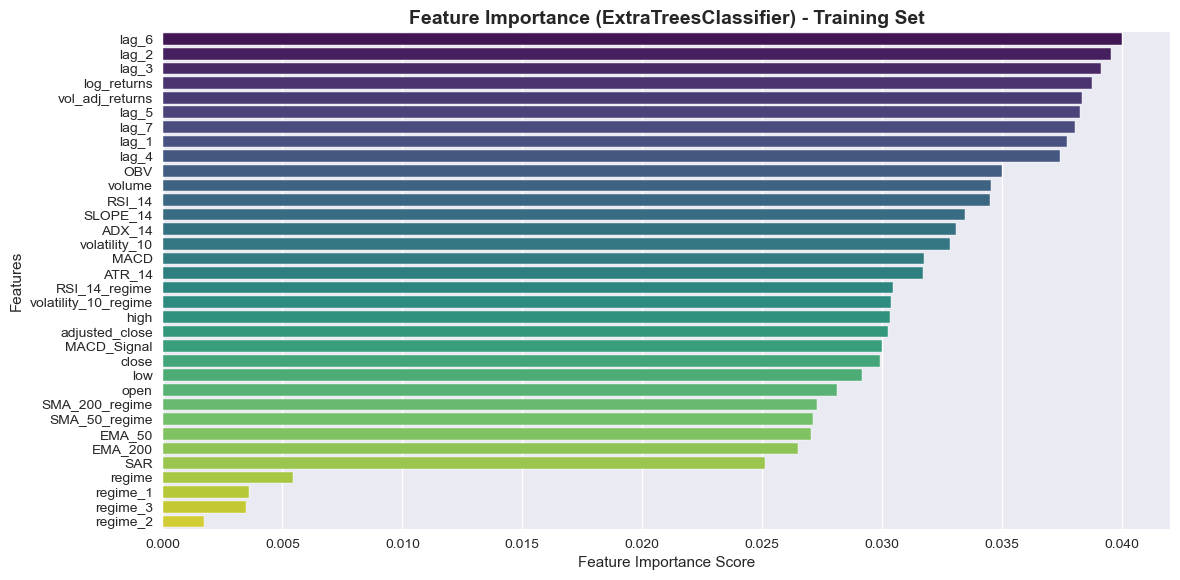

Top 15 features (Training Set): ['lag_6', 'lag_2', 'lag_3', 'log_returns', 'vol_adj_returns', 'lag_5', 'lag_7', 'lag_1', 'lag_4', 'OBV', 'volume', 'RSI_14', 'SLOPE_14', 'ADX_14', 'volatility_10']
X_train_selected shape: (1996, 15)
X_test_selected shape: (797, 15)


In [14]:
# 1) Define a chronological cutoff date
train_cutoff = '2022-01-01'  # or pick another date

df_train = df.loc[:train_cutoff]
df_test = df.loc[train_cutoff:]

X_train = X.loc[df_train.index]
y_train = y.loc[df_train.index]
X_test = X.loc[df_test.index]
y_test = y.loc[df_test.index]

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# 2) Fit ExtraTrees ONLY on the training set
model_fs = ExtraTreesClassifier(n_estimators=100, random_state=42)
model_fs.fit(X_train, y_train)

# 3) Extract feature importances from TRAINING
feature_importance = pd.Series(
    model_fs.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# (Optional) plot these feature importances
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance.values, 
    y=feature_importance.index, 
    hue=feature_importance.index,
    palette="viridis",
    dodge=False,
    legend=False
)
plt.title("Feature Importance (ExtraTreesClassifier) - Training Set", fontsize=14, fontweight='bold')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "4_feature_importance_extratrees.png", dpi=100)  # or .pdf/.svg if needed
plt.show()

# 4) Select top N features from TRAINING
n_top = 15
top_features = feature_importance.index[:n_top]
print(f"Top {n_top} features (Training Set):", top_features.tolist())

# 5) Apply these features to both train & test
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print("X_train_selected shape:", X_train_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)


### Preparation of `X` and `y` for LSTM Model

In [15]:
##############################
# Step 2: Scale Training Only
##############################
scaler = StandardScaler()
scaler.fit(X_train)            # Fit on training
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Transform test with same scaler

# Convert back to DataFrame for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

##############################
# Step 3: Use Top Features
##############################
# 'top_features' is assumed to be known (selected from a training-only feature selection step)
# e.g., top_features = ['RSI_14', 'lag_6', 'lag_3', 'lag_5', 'vol_adj_returns', ...]
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

# Align target with these new DataFrame indices
y_train = y_train.loc[X_train_selected.index]
y_test = y_test.loc[X_test_selected.index]

print("X_train_selected shape:", X_train_selected.shape)
print("y_train shape:", y_train.shape)
print("X_test_selected shape:", X_test_selected.shape)
print("y_test shape:", y_test.shape)

##############################
# Step 4: Sequence Creation
##############################
def create_sequences(X_df, y_series, seq_length=7):
    """
    Generates sequences from a DataFrame (X_df) and aligns with the target (y_series).
    Returns (X_seq, y_seq).
    """
    X_values = X_df.values  
    y_values = y_series.values  
    
    # For each valid starting index i, the sequence is [i : i + seq_length]
    X_seq = np.array([
        X_values[i : i + seq_length] 
        for i in range(len(X_values) - seq_length)
    ])
    # The label for that sequence is y at index i+seq_length
    y_seq = y_values[seq_length:]  
    
    return X_seq, y_seq

sequence_length = 7

# Safety checks
if len(X_train_selected) < sequence_length:
    raise ValueError("Not enough training data to generate sequences! Adjust sequence_length or dataset.")
if len(X_test_selected) < sequence_length:
    raise ValueError("Not enough test data to generate sequences! Adjust sequence_length or dataset.")

# Generate training sequences
X_seq_train, y_seq_train = create_sequences(X_train_selected, y_train, seq_length=sequence_length)
# Generate test sequences
X_seq_test, y_seq_test = create_sequences(X_test_selected, y_test, seq_length=sequence_length)

##############################
# Step 5: Confirm Shapes
##############################
print("\nSequence Shapes:")
print(f"X_seq_train: {X_seq_train.shape} (Samples={X_seq_train.shape[0]}, Time Steps={sequence_length}, Features={X_seq_train.shape[2]})")
print(f"y_seq_train: {y_seq_train.shape} (Samples={y_seq_train.shape[0]})")
print(f"X_seq_test:  {X_seq_test.shape} (Samples={X_seq_test.shape[0]}, Time Steps={sequence_length}, Features={X_seq_test.shape[2]})")
print(f"y_seq_test:  {y_seq_test.shape} (Samples={y_seq_test.shape[0]})")

X_train_selected shape: (1996, 15)
y_train shape: (1996,)
X_test_selected shape: (797, 15)
y_test shape: (797,)

Sequence Shapes:
X_seq_train: (1989, 7, 15) (Samples=1989, Time Steps=7, Features=15)
y_seq_train: (1989,) (Samples=1989)
X_seq_test:  (790, 7, 15) (Samples=790, Time Steps=7, Features=15)
y_seq_test:  (790,) (Samples=790)


# Model Implementation & Training
## Model Definition & Initialization

#### CNN-LSTM Model

In [16]:
# --- Model Implementation & Training ---
# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ==========================
# Configuration Parameters
# ==========================
SEQUENCE_LENGTH = X_seq_train.shape[1]   # 7
N_FEATURES = X_seq_train.shape[2]        # 15

CONV_FILTERS = 64
KERNEL_SIZE = 3
LSTM_UNITS = 64
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001

# ==========================
# Model Definition
# ==========================
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, N_FEATURES)),
    Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    Dropout(DROPOUT_RATE),
    MaxPooling1D(pool_size=2),
    LSTM(LSTM_UNITS, return_sequences=False, dropout=DROPOUT_RATE),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

# ==========================
# Compilation
# ==========================
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# ==========================
# Model Summary
# ==========================
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             2944      
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 64)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [20]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# ================================
# Hyperparameters
# ================================
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
CONV_FILTERS = 64
KERNEL_SIZE = 3
LSTM_UNITS = 64
DROPOUT_RATE = 0.3

# ====================================================
# CNN-LSTM model factory
# ====================================================
def get_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
        Dropout(DROPOUT_RATE),
        MaxPooling1D(pool_size=2),
        LSTM(LSTM_UNITS, return_sequences=False, dropout=DROPOUT_RATE),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=['accuracy']
    )
    return model

# ====================================================
# Time-Series Cross-Validation Setup
# ====================================================
tscv = TimeSeriesSplit(n_splits=6, test_size=252)

predictions, true_labels = [], []
fold_metrics = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq_train)):
    print(f"Processing Fold {fold + 1}/{tscv.n_splits}...")

    # Extract fold data
    X_train_fold = X_seq_train[train_index]
    X_test_fold = X_seq_train[test_index]
    y_train_fold = y_seq_train[train_index]
    y_test_fold = y_seq_train[test_index]

    # Scale fold data (3D ➝ 2D ➝ 3D)
    nsamples_train, timesteps, n_feats = X_train_fold.shape
    X_train_fold_2d = X_train_fold.reshape(-1, n_feats)

    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold_2d).reshape(X_train_fold.shape)
    X_test_fold_scaled = scaler.transform(X_test_fold.reshape(-1, n_feats)).reshape(X_test_fold.shape)

    # Build and train model
    model = get_cnn_lstm_model((timesteps, n_feats))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train_fold_scaled, y_train_fold,
        validation_data=(X_test_fold_scaled, y_test_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stopping]
    )

    # Predict and store results
    pred = model.predict(X_test_fold_scaled, verbose=0).flatten()
    pred_binary = (pred >= 0.5).astype(int)

    predictions.extend(pred)
    true_labels.extend(y_test_fold)

    # Compute and store fold metrics (zero_division=0 added here)
    fold_metrics.append({
        "fold": fold + 1,
        "accuracy": accuracy_score(y_test_fold, pred_binary),
        "precision": precision_score(y_test_fold, pred_binary, zero_division=0),
        "recall": recall_score(y_test_fold, pred_binary, zero_division=0),
        "f1_score": f1_score(y_test_fold, pred_binary, zero_division=0)
    })

# ====================================================
# Save & Display Aggregate Metrics
# ====================================================
predictions = np.array(predictions)
true_labels = np.array(true_labels)

df_fold_metrics = pd.DataFrame(fold_metrics)
df_fold_metrics.to_csv(OUTPUT_DIR / "fold_metrics.csv", index=False)

print("Fold Metrics:")
display(df_fold_metrics)

# Overall performance (zero_division=0 added here too)
predictions_binary = (predictions >= 0.5).astype(int)
print("Cross-Validated Model Performance (Training Set):")
print(f"Accuracy: {accuracy_score(true_labels, predictions_binary):.4f}")
print(f"Precision: {precision_score(true_labels, predictions_binary, zero_division=0):.4f}")
print(f"Recall: {recall_score(true_labels, predictions_binary, zero_division=0):.4f}")
print(f"F1-score: {f1_score(true_labels, predictions_binary, zero_division=0):.4f}")

print("Mean Fold Performance:")
print(df_fold_metrics[["accuracy", "precision", "recall", "f1_score"]].mean())


Processing Fold 1/6...
Processing Fold 2/6...
Processing Fold 3/6...
Processing Fold 4/6...
Processing Fold 5/6...
Processing Fold 6/6...
Fold Metrics:


,fold,accuracy,precision,recall,f1_score
0,1,0.535714,0.549296,0.595420,0.571429
1,2,0.484127,0.559322,0.458333,0.503817
2,3,0.496032,0.515152,0.643939,0.572391
3,4,0.595238,0.595238,1.000000,0.746269
4,5,0.571429,0.571429,1.000000,0.727273
5,6,0.571429,0.571429,1.000000,0.727273


Cross-Validated Model Performance (Training Set):
Accuracy: 0.5423
Precision: 0.5648
Recall: 0.7893
F1-score: 0.6584
Mean Fold Performance:
accuracy     0.542328
precision    0.560311
recall       0.782949
f1_score     0.641408
dtype: float64


#### `Saving & Logging`

In [21]:
# Save the best model from cross-validation
model.save("best_cnn_lstm_model.keras")

# Backup in case of overwriting
shutil.copy("best_cnn_lstm_model.keras", "best_cnn_lstm_model_backup.keras")


'best_cnn_lstm_model_backup.keras'

**Up to this section, we have put together a production-grade pipeline for an LSTM-based trading strategy.**  

# Trading Signal Generation and Backtesting Module

In [22]:
@dataclass
class BTConfig:
    # Signal thresholds (probabilities)
    long_threshold: float = 0.55
    short_threshold: float = 0.45
    neutral_band: bool = True  # if True, do nothing in (short_th, long_th)

    # Position management
    min_hold_days: int = 3              # minimum holding period (bars)
    stop_daily: float = -0.025          # daily stop: exit if pos*ret <= this (log-return)
    stop_trailing: float = -0.06        # trailing stop since entry (log-return)
    roll_loss_window: int = 10          # rolling window for loss exit
    roll_loss_thresh: float = -0.05     # exit if rolling pos*ret sum < this

    # Vol targeting
    use_vol_targeting: bool = True
    vol_window: int = 30                # rolling window for realized vol (daily)
    target_annual_vol: float = 0.15     # e.g., 15% annual vol target
    max_leverage: float = 2.0           # cap on |position_size|
    vol_floor: float = 1e-6             # avoid div by zero

    # Transaction costs
    cost_bps_per_turnover: float = 10   # 10 bps per unit turnover (0.001 = 10 bps)
    slippage_bps: float = 0.0           # optional extra slippage per trade leg

def align_predictions_to_df(df: pd.DataFrame,
                            predictions: np.ndarray | pd.Series,
                            pred_index: pd.DatetimeIndex | None = None,
                            column_name: str = "p") -> pd.Series:
    """
    Returns a Series aligned to df.index containing the predictions.
    If pred_index is provided, we reindex to df (preserving order).
    Otherwise we right-align to the last len(predictions) rows.
    """
    if isinstance(predictions, pd.Series):
        s = predictions.copy()
    else:
        if pred_index is not None:
            s = pd.Series(predictions, index=pred_index)
        else:
            if len(predictions) > len(df):
                raise ValueError("predictions length exceeds df length; provide pred_index to align.")
            s = pd.Series(predictions, index=df.index[-len(predictions):])
    return s.reindex(df.index).rename(column_name)

def run_backtest_clean(
    df: pd.DataFrame,
    predictions: np.ndarray | pd.Series,
    pred_index: pd.DatetimeIndex | None = None,
    cfg: BTConfig = BTConfig(),
    price_col: str = "adjusted_close",
    ret_col: str = "log_returns",
) -> tuple[pd.DataFrame, dict]:
    """
    Clean event-driven backtest with:
      - strict alignment & no look-ahead
      - min hold, daily stop, trailing stop, rolling-loss exit
      - volatility targeting with caps & floors
      - turnover-based transaction costs
      - buy/hold benchmark & performance summary

    Requires df[ret_col] (daily log returns) and df[price_col] (for benchmark).
    """
    if ret_col not in df.columns:
        raise KeyError(f"Expected {ret_col} in df")
    if price_col not in df.columns:
        raise KeyError(f"Expected {price_col} in df")

    out = df[[ret_col, price_col]].copy()
    out["p"] = align_predictions_to_df(df, predictions, pred_index, "p")

    # 1) Raw signal from probabilities
    if cfg.neutral_band:
        out["raw_signal"] = np.select(
            [out["p"] >= cfg.long_threshold, out["p"] <= cfg.short_threshold],
            [1, -1], default=0
        )
    else:
        out["raw_signal"] = np.where(out["p"] >= cfg.long_threshold, 1, -1)

    # 2) Realized volatility & position sizing scalar
    if cfg.use_vol_targeting:
        vol = out[ret_col].rolling(cfg.vol_window).std()
        # Fill early NaNs with expanding std as a reasonable fallback, then final backstop
        vol = vol.fillna(out[ret_col].expanding().std()).fillna(0.0)
        out["vol_est_daily"] = vol

        target_daily_vol = cfg.target_annual_vol / np.sqrt(252.0)
        denom = out["vol_est_daily"].clip(lower=cfg.vol_floor)
        scale = (target_daily_vol / denom).clip(upper=cfg.max_leverage)
        # Final safety: if anything is still NA/inf, default to 1.0
        scale = scale.replace([np.inf, -np.inf], np.nan).fillna(1.0)
    else:
        scale = pd.Series(1.0, index=out.index)

    # 3) Event-driven loop (no look-ahead)
    pos = 0            # direction: -1, 0, +1
    size = 0.0         # signed position size after vol targeting
    days_held = 0
    entry_cum_logret = 0.0
    rolling_buf: list[float] = []

    pos_hist, size_hist = [], []
    daily_pos_ret, turn_hist, cost_hist = [], [], []
    trail_hist, sig_hist = [], []

    cost_per_turnover = (cfg.cost_bps_per_turnover + cfg.slippage_bps) / 1e4

    for i, idx in enumerate(out.index):
        p = out.at[idx, "p"]
        r = out.at[idx, ret_col]
        s_raw = out.at[idx, "raw_signal"]

        # Desired direction (respect min_hold_days)
        desired_pos = pos
        if not np.isnan(p):
            if days_held > 0:
                desired_pos = pos
                days_held -= 1
            else:
                desired_pos = s_raw

        # Use previous size for today's P&L (no look-ahead)
        daily_pret = size * r
        daily_pos_ret.append(daily_pret)

        # Update trailing since entry
        if pos == 0:
            entry_cum_logret = 0.0
        else:
            entry_cum_logret += daily_pret
        trail_hist.append(entry_cum_logret)

        # Rolling loss buffer (pos*ret)
        rolling_buf.append(daily_pret)
        if len(rolling_buf) > cfg.roll_loss_window:
            rolling_buf.pop(0)
        rolling_sum = float(np.sum(rolling_buf))

        # Check exits (hard exits override desired entries)
        exit_signal = False
        if pos != 0:
            if daily_pret <= cfg.stop_daily:
                exit_signal = True
            if entry_cum_logret <= cfg.stop_trailing:
                exit_signal = True
            if (len(rolling_buf) == cfg.roll_loss_window) and (rolling_sum <= cfg.roll_loss_thresh):
                exit_signal = True

        # Determine next position (direction), respecting exits
        next_pos = 0 if exit_signal else desired_pos

        # Compute next size with vol targeting
        s = float(scale.iloc[i])
        next_size = float(np.clip(next_pos * s, -cfg.max_leverage, cfg.max_leverage))

        # Turnover & cost applied on change from current size -> next size
        turnover = abs(next_size - size)
        cost = cost_per_turnover * turnover

        # Record & advance
        pos_hist.append(pos)
        size_hist.append(size)
        turn_hist.append(turnover)
        cost_hist.append(cost)
        sig_hist.append(s_raw)

        # If we open a new position, (0 -> ±1) enforce min hold going forward
        if (pos == 0) and (next_pos != 0):
            days_held = max(cfg.min_hold_days - 1, 0)
            entry_cum_logret = 0.0

        pos = next_pos
        size = next_size

    out["pos_dir_prev"]   = pos_hist           # previous-bar direction (info)
    out["pos_size_prev"]  = size_hist          # previous-bar size used for P&L
    out["signal_raw"]     = sig_hist
    out["turnover"]       = turn_hist
    out["cost"]           = cost_hist
    out["pos_ret"]        = daily_pos_ret      # size_prev * ret
    out["pos_trail"]      = trail_hist

    # Net strategy log return (subtract costs)
    out["strat_log_ret"] = out["pos_ret"] - out["cost"]

    # Equity curves
    out["strategy_equity"] = np.exp(out["strat_log_ret"].cumsum())
    out["bh_log_ret"]      = out[ret_col]  # buy & hold (1x)
    out["bh_equity"]       = np.exp(out["bh_log_ret"].cumsum())

    # Focus metrics on the period where we actually had predictions
    mask_test = out["p"].notna()
    test = out.loc[mask_test].copy()
    if test.empty:
        raise ValueError("No rows with predictions; check alignment.")

    # Performance summary helpers
    def max_drawdown(equity: pd.Series) -> float:
        roll_max = equity.cummax()
        dd = equity / roll_max - 1.0
        return float(dd.min())  # negative number

    def annualize_mean_logret(daily_logret: pd.Series) -> float:
        return float(daily_logret.mean() * 252.0)

    def annualize_vol(daily_logret: pd.Series) -> float:
        return float(daily_logret.std(ddof=0) * np.sqrt(252.0))

    # Strategy stats
    strat_log = test["strat_log_ret"]
    bh_log    = test["bh_log_ret"]

    strat_total_ret = float(np.exp(strat_log.sum()) - 1.0)
    bh_total_ret    = float(np.exp(bh_log.sum()) - 1.0)

    strat_cagr = float(np.exp(annualize_mean_logret(strat_log)) - 1.0)
    bh_cagr    = float(np.exp(annualize_mean_logret(bh_log)) - 1.0)

    strat_vol = annualize_vol(strat_log)
    bh_vol    = annualize_vol(bh_log)

    # Add tiny epsilon to avoid 0/0
    eps = 1e-12
    strat_sharpe = float(annualize_mean_logret(strat_log) / (strat_vol + eps))
    bh_sharpe    = float(annualize_mean_logret(bh_log) / (bh_vol + eps))

    strat_mdd = max_drawdown(test["strategy_equity"])
    bh_mdd    = max_drawdown(test["bh_equity"])

    turnover_sum = float(test["turnover"].sum())
    # Fraction of profitable days while exposed (size_prev ≠ 0)
    exposed = test["pos_size_prev"] != 0
    hit_rate = float((test.loc[exposed, "pos_ret"] > 0).mean()) if exposed.any() else np.nan

    summary = {
        "window_start": str(test.index[0].date()),
        "window_end":   str(test.index[-1].date()),
        "bars": int(len(test)),
        "total_return":      strat_total_ret,
        "bh_total_return":   bh_total_ret,
        "cagr":              strat_cagr,
        "bh_cagr":           bh_cagr,
        "ann_vol":           strat_vol,
        "bh_ann_vol":        bh_vol,
        "sharpe":            strat_sharpe,
        "bh_sharpe":         bh_sharpe,
        "max_drawdown":      strat_mdd,
        "bh_max_drawdown":   bh_mdd,
        "turnover":          turnover_sum,
        "hit_rate":          hit_rate,
        "avg_daily_cost_bps": float(test["cost"].mean() * 1e4),
        "avg_daily_exposure": float(test["pos_size_prev"].abs().mean()),
    }

    return out, summary


In [23]:
df_backtest, bt_summary = run_backtest_clean(df, predictions)
print("\nSummary:\n")
print(tabulate(bt_summary.items(), headers=["Metric", "Value"], floatfmt=".4f"))


Summary:

Metric              Value
------------------  --------------------
window_start        2019-03-05
window_end          2025-03-07
bars                1512
total_return        0.4154797116248312
bh_total_return     1.0660911388139254
cagr                0.05962112544921472
bh_cagr             0.1285606735015068
ann_vol             0.10629726557628427
bh_ann_vol          0.20200853129668933
sharpe              0.5448062571982977
bh_sharpe           0.5987028358977308
max_drawdown        -0.12338169944827837
bh_max_drawdown     -0.3392496002613472
turnover            210.52419743276428
hit_rate            0.553125
avg_daily_cost_bps  1.392355803126748
avg_daily_exposure  0.4964584897143817


# AI Strategy Performance Review

## Plot 1: Actual Returns vs Predicted Returns
Shows how well the signals align with actual movements.

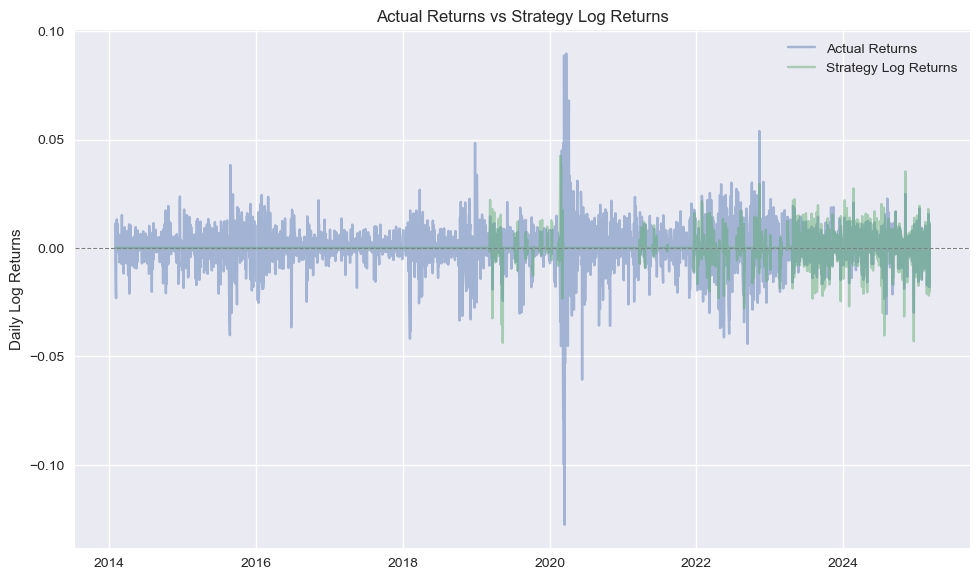

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(df_backtest.index, df_backtest['log_returns'], label="Actual Returns", alpha=0.45)
plt.plot(df_backtest.index, df_backtest['strat_log_ret'], label="Strategy Log Returns", alpha=0.45)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Actual Returns vs Strategy Log Returns")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "5_actual_vs_predicted_returns.png", dpi=100)
plt.show()


## Plot 2: Equity Curve of the Strategy
Show the cumulative performance over time.

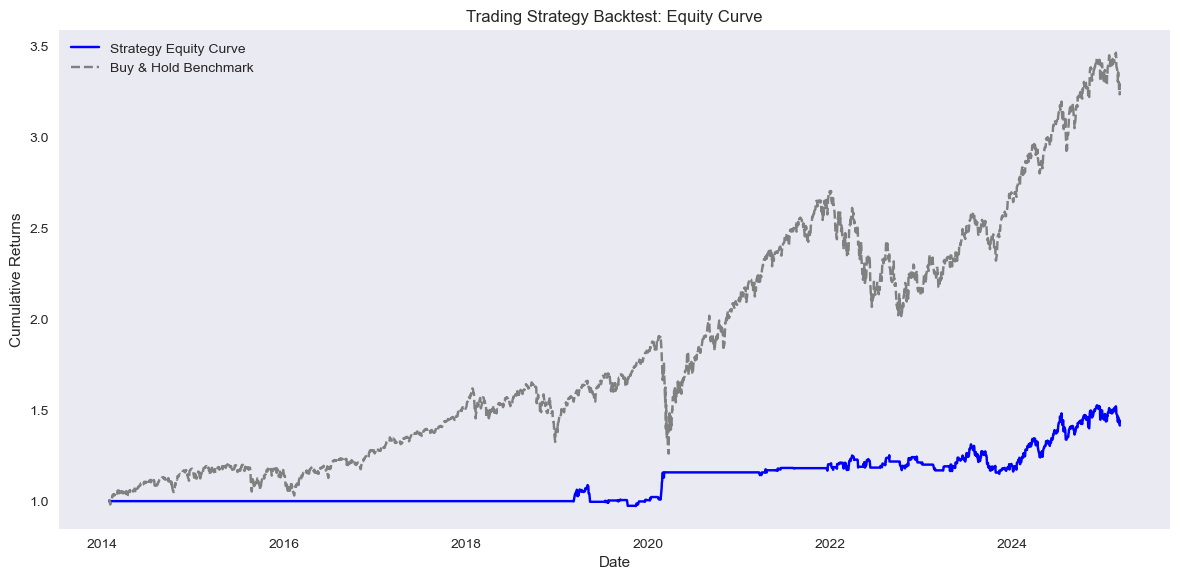

In [25]:
plt.figure(figsize=(12, 6))

# Strategy equity curve
plt.plot(df_backtest.index, df_backtest['strategy_equity'],
         label="Strategy Equity Curve", color='blue')

# Buy & Hold baseline
plt.plot(df_backtest.index, df_backtest['bh_equity'],
         label="Buy & Hold Benchmark", color='gray', linestyle="--")

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Trading Strategy Backtest: Equity Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "6_equity_curve_strategy.png", dpi=100)
plt.show()


## Plot 3: Strategy vs. Benchmark Comparison
Illustrate whether the strategy outperforms a simple buy-and-hold benchmark.

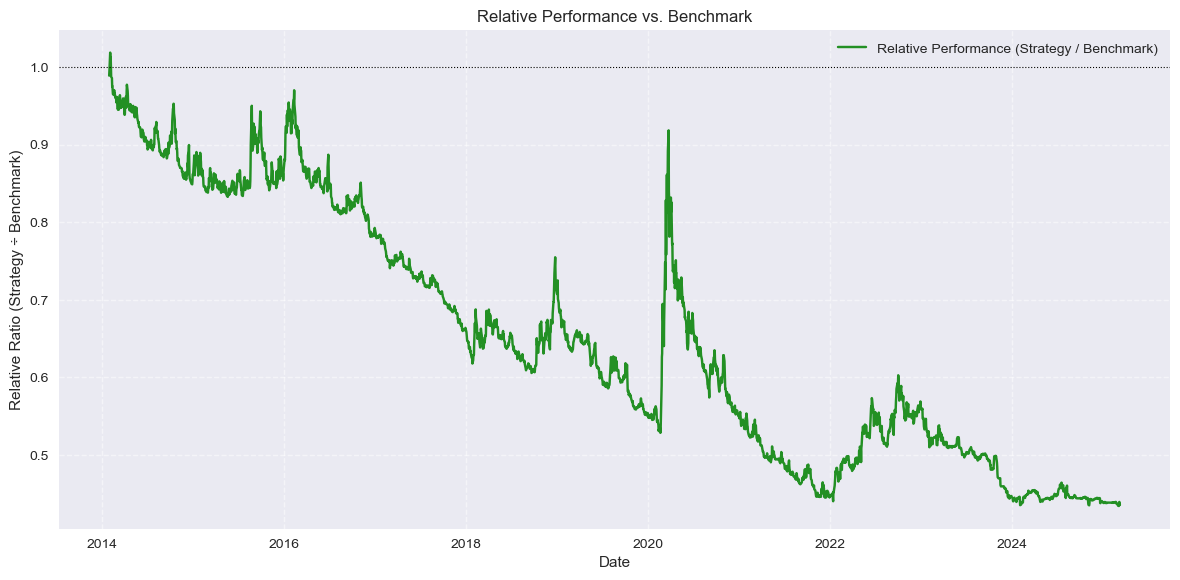

In [26]:
# Pure Relative Performance (Strategy / Benchmark)
plt.figure(figsize=(12, 6))

df_backtest['relative_perf'] = df_backtest['strategy_equity'] / df_backtest['bh_equity']

plt.plot(df_backtest.index, df_backtest['relative_perf'],
         label="Relative Performance (Strategy / Benchmark)", color="green", alpha=0.85)

plt.axhline(y=1.0, color='black', linestyle=':', linewidth=0.8)
plt.title("Relative Performance vs. Benchmark")
plt.ylabel("Relative Ratio (Strategy ÷ Benchmark)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "7_relative_performance.png", dpi=300)
plt.show()


## `quantstats` Analytics Module


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-03-08   2019-03-08
End Period          2025-03-07   2025-03-07
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       49.0%

Cumulative Return   109.91%      41.55%
CAGR﹪              8.9%         4.08%

Sharpe              0.72         0.6
Prob. Sharpe Ratio  95.78%       92.71%
Sortino             1.0          0.86
Sortino/√2          0.71         0.61
Omega               1.17         1.17

Max Drawdown        -33.92%      -12.34%
Longest DD Days     745          308

Gain/Pain Ratio     0.15         0.17
Gain/Pain (1M)      0.8          0.66

Payoff Ratio        0.99         1.1
Profit Factor       1.15         1.17
Common Sense Ratio  1.09         1.39
CPC Index           0.62         0.61
Tail Ratio          0.95         1.19
Outlier Win Ratio   3.0          10.34
Outlier Loss Ratio  3.33         4.66

MTD                 -3.1%        -3.18%
3M            

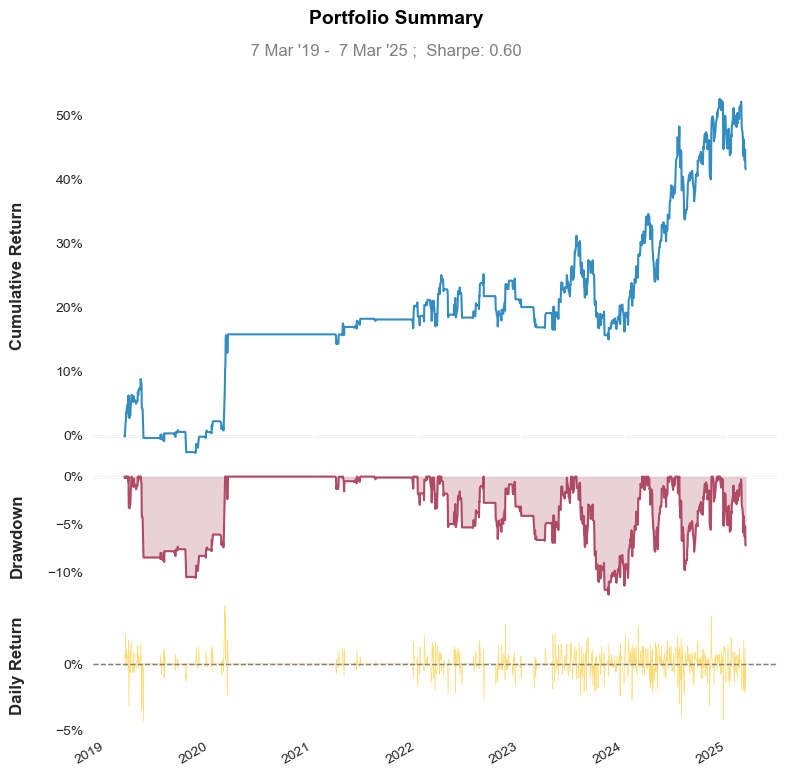

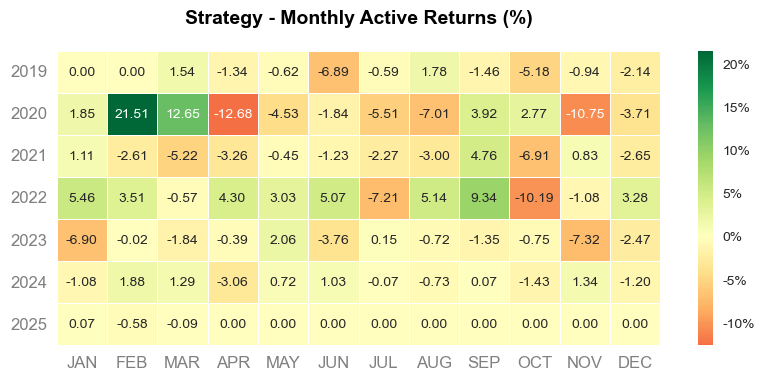

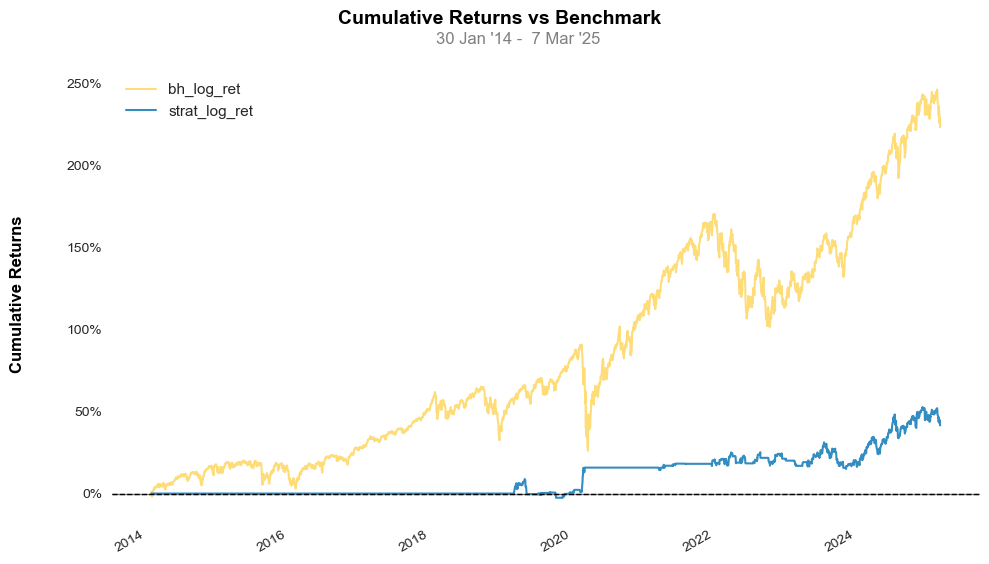

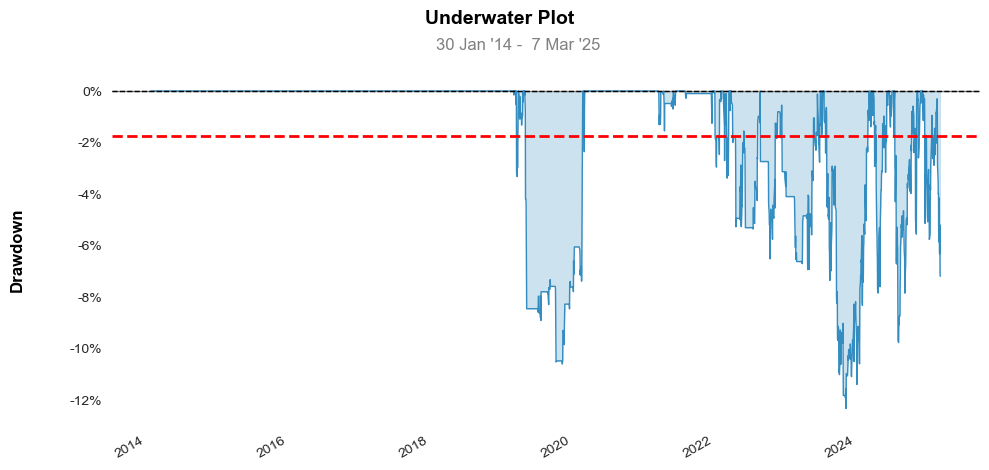

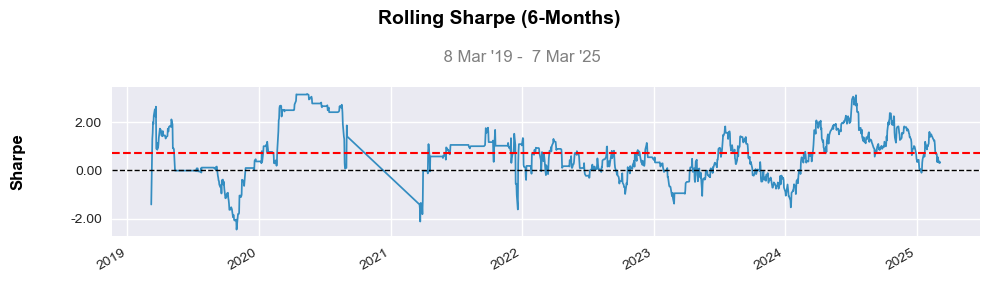

In [27]:
# Convert log returns to simple daily returns
strategy_simple_returns = np.exp(df_backtest['strat_log_ret']) - 1
benchmark_simple_returns = np.exp(df_backtest['bh_log_ret']) - 1

# Generate a Performance Report
qs.reports.basic(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Cumulative Returns Comparison (Strategy vs. Benchmark)
qs.plots.returns(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Drawdown Analysis
qs.plots.drawdown(strategy_simple_returns)

# Rolling Sharpe Ratio
qs.plots.rolling_sharpe(strategy_simple_returns)


In [28]:
# === Export Clean CNN-LSTM Model Results (Fixed) ===
df_cnn_lstm = df_backtest[['log_returns', 'p', 'strat_log_ret']].copy()
df_cnn_lstm.rename(columns={
    'p': 'predictions',
    'strat_log_ret': 'strategy_log_return'  # alias to keep downstream code happy
}, inplace=True)

# Drop rows with missing predictions (common in time series)
df_cnn_lstm.dropna(subset=['predictions'], inplace=True)

# Confirm structure
print(df_cnn_lstm.head())
print(df_cnn_lstm.shape)

df_cnn_lstm.to_csv(OUTPUT_DIR / 'df_cnn_lstm.csv', index=False)


            log_returns  predictions  strategy_log_return
Date                                                     
2019-03-05    -0.001132     0.514499            -0.000000
2019-03-06    -0.006545     0.525264            -0.000000
2019-03-07    -0.008159     0.543301            -0.000000
2019-03-08    -0.002134     0.554149            -0.001529
2019-03-11     0.014560     0.590649             0.022187
(1512, 3)
